# How-to train an object detection model

This notebook shows how run one "experiment" and train a new model. 

Training consists of two parts:
   1. Training a CNN for multi-classification on **single** food items (using transfer learning).
   2. Tuning the sliding window algorithm for optimal performance on both valdiation sets (real and artificial).
    
This notebook carries you through the process and explains the individual steps.

An automatized script which goes through the whole process is given in **XXXX**.

In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import glob, os
import datetime

import data.data_helpers as data_helpers
import models.model_helpers as model_helpers
import models.tuning_helpers as tuning_helpers
import models.training_vis as training_vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define parameter dictionary

This dictionary will be saved along with the trained model to log the results. 

Things to do before running a new experiment:
   1. Define folder from which to take data
   1. Define experiment name
   3. Define model architecture and other hyperparameters

In [7]:
# whether to log the results to json:
logging = True

# whether to save the model:
saving  = True

### Specify folders from which to take data:
data_directories = [
    'data/FIDS30',
    'data/original_clean',
    'data/update_9sep',
    'data/marianne_update',
    'data/data_gleb_upsample',
]

real_validation_path = 'data/validation_real/'
real_artificial_path = 'data/validation_artificial/'


PARAMS = {

    ### Define experiment name:
    'experiment_name': 'test_all',
    
    ### Parameters for the CNN:
    'data_directories': data_directories,
    'test_size': 0.1,
    'seed': 11,
    'batch_size': 32,
    'target_size': (112,112),
    'epochs_cold': 1,
    'epochs_finetune': 1,
    'lr_cold': 0.001,
    'lr_finetune': 1e-5,
    
    'base_net': 'mobilenet_v2', # supported: resnet50/mobilenet_v2
    'head_net': '[tf.keras.layers.GlobalAveragePooling2D(),\
                 tf.keras.layers.Dropout(0.2)]',
    
    # The following parameters are for tuning the sliding window algorithm:
    'real_validation_path': real_validation_path,
    'artificial_validation_path': real_artificial_path,
    'thr_list': [0.9, 0.93, 0.96],
    'overlap_thr_list': [0.2, 0.3, 0.5],#list(np.arange(0,1,0.05)),
    'scaling_factors': [1.0, 1.5, 2.0],
    'sliding_strides': [32, 64, 128]
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/scalars/{PARAMS["experiment_name"]}_' + datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)
        
    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]
else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []
    

Log results to logs/experiments/test_all_2020_09_16-11:32


### Load train and test data

In [8]:
data_df_train, data_df_test, classes, class2ind, ind2class = \
data_helpers.get_train_test_data_df(PARAMS['data_directories'], PARAMS['test_size'], PARAMS['seed'])

### Set up data pipeline

 - Use keras-ImageDataGenerator for pre-processing and define data augmentations
 - Create keras-DataFrameIterators as an input to the model 

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet_v2
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define preprocessing function
if PARAMS['base_net'] == 'resnet50':
    preprocess_function = preprocess_resnet50
elif PARAMS['base_net'] == 'mobilenet_v2':
    preprocess_function = preprocess_mobilenet_v2

# crea ImageDataGenerator with data augmentations
image_generator_train = ImageDataGenerator(horizontal_flip=True,
                                           vertical_flip=True,
                                           rotation_range=180,
                                           shear_range=30,
                                           zoom_range=[0.5,1],
                                           preprocessing_function=preprocess_function)

image_generator_test = ImageDataGenerator(preprocessing_function=preprocess_function)

# create data iterators
train_iterator = data_helpers.get_data_frame_iterator(data_df_train, image_generator_train, PARAMS)
test_iterator = data_helpers.get_data_frame_iterator(data_df_test, image_generator_test, PARAMS)

Found 8235 validated image filenames belonging to 53 classes.
Found 915 validated image filenames belonging to 53 classes.


### Show some example pictures from the train set

 - Use `deprocess_func=None` for MobileNet
 - Use `deprocess_func=data_helpers.deprocess_imagenet` for Resnet50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

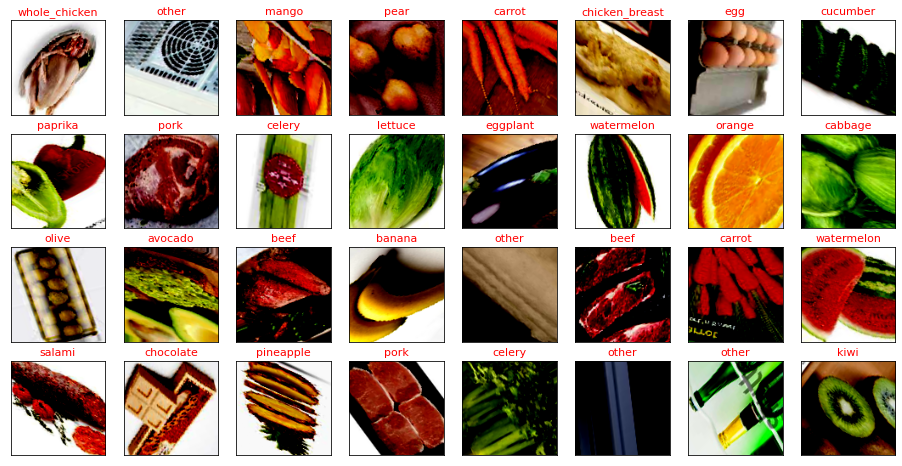

In [10]:
# generate example batch
image_batch, label_batch = next(train_iterator)

# get correct image deprocessing function for proper visualization of images
if PARAMS['base_net'] == 'mobilenet_v2':
    plot_deprocess_func = None
else:
    plot_deprocess_func = data_helpers.deprocess_imagenet

# generat figure
fig = data_helpers.image_grid(image_batch, label_batch, ind2class, n_row=4, n_col=8, deprocess_func=plot_deprocess_func)

if logging:
    if not os.path.exists(os.path.join(logdir, 'figures')):
        os.makedirs(os.path.join(logdir, 'figures'))
    fig.savefig(os.path.join(logdir, 'figures/training_examples.png'), bbox_inches='tight')

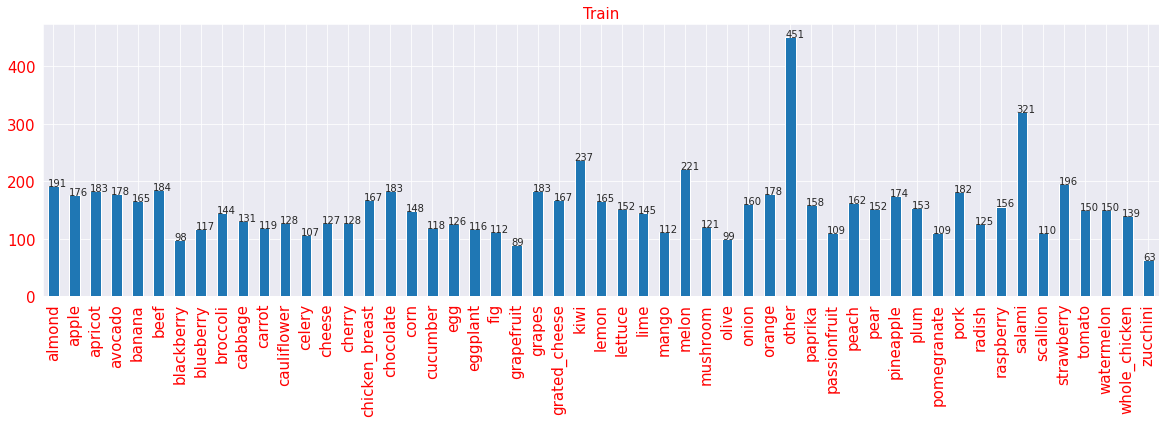

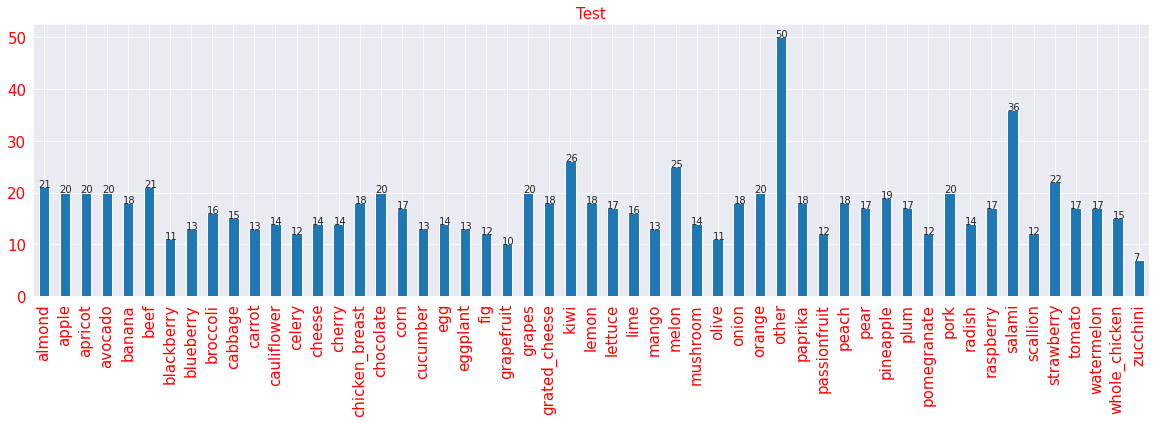

In [11]:
with sns.axes_style('darkgrid'):
    fig = data_helpers.show_label_distribution(data_df_train, ind2class, 'Train')
    if logging:
        fig.savefig(os.path.join(logdir, 'figures/training_distribution.png'), bbox_inches='tight')

    fig = data_helpers.show_label_distribution(data_df_test, ind2class, 'Test')

### Generate model

Create the model using a transfer learning approach.

 - Download pre-trained base model
 - Freeze all layers of the base model 
 - Append a custom head using the Sequential API
 - Compile the model

In [12]:
from tensorflow.keras.optimizers import Adam

# download pre-trained model
if PARAMS['base_net'] == 'resnet50':
    pretrained_model = tf.keras.applications.ResNet50(input_shape=PARAMS['target_size']+(3,), 
                                                      include_top=False)
elif PARAMS['base_net'] == 'mobilenet_v2':
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=PARAMS['target_size']+(3,), 
                                                      include_top=False)

# freeze pre-trained model 
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    *eval(PARAMS['head_net']),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=PARAMS['lr_cold']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 53)                67893     
Total params: 2,325,877
Trainable params: 67,893
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the head of the model (with the base frozen)

In [14]:
steps_per_epoch = len(train_iterator.filenames)//PARAMS['batch_size']+1

history_cold = model.fit_generator(
    train_iterator, 
    validation_data=test_iterator,
	epochs=PARAMS['epochs_cold'], 
    steps_per_epoch=steps_per_epoch,
    callbacks=tensorboard_callbacks)

258/258 [==============================] - 110s 424ms/step - loss: 1.1314 - accuracy: 0.6730 - val_loss: 1.0088 - val_accuracy: 0.6995


### Train the head of the model (with the base un-frozen)

In [15]:
pretrained_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=PARAMS['lr_finetune']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit_generator(
    train_iterator, 
    validation_data=test_iterator,
	epochs=PARAMS['epochs_cold']+PARAMS['epochs_finetune'], 
    steps_per_epoch=steps_per_epoch,
    callbacks=tensorboard_callbacks,
    initial_epoch=PARAMS['epochs_cold'])

Epoch 2/2
258/258 [==============================] - 292s 1s/step - loss: 2.1585 - accuracy: 0.4226 - val_loss: 1.0097 - val_accuracy: 0.7038


In [18]:
# append both histories 
history = {k: v + history_finetune.history[k] for (k,v) in history_cold.history.items()}

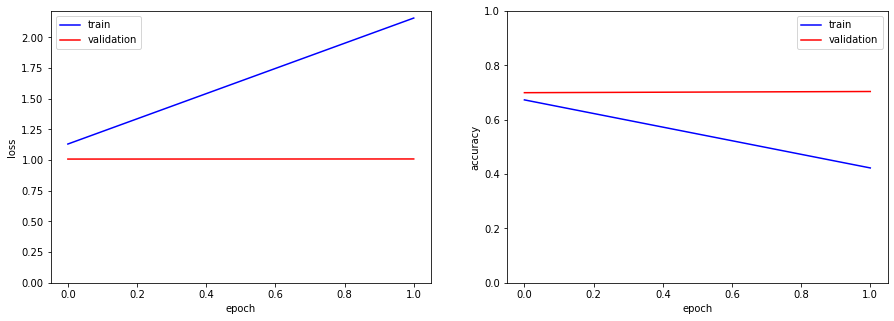

In [17]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)
plt.plot(history['loss'], 'b')
plt.plot(history['val_loss'], 'r')
plt.ylim([0, None])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'])

ax = plt.subplot(122)
plt.plot(history['accuracy'], 'b')
plt.plot(history['val_accuracy'], 'r')
plt.ylim([0,1])
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'])

if logging:
    fig.savefig(os.path.join(logdir, 'figures/loss_accuracy_training.png'), bbox_inches='tight')

### Look at results

 - Generate predictions on the whole test set
 - Look at some predictions
 - Look at the most wrong predictions

In [19]:
# predict on the whole set
images, labels, predict_i, predict_proba, predict_labels, ind_misclassified = model_helpers.predict_on_whole_dataset(model, test_iterator, ind2class)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

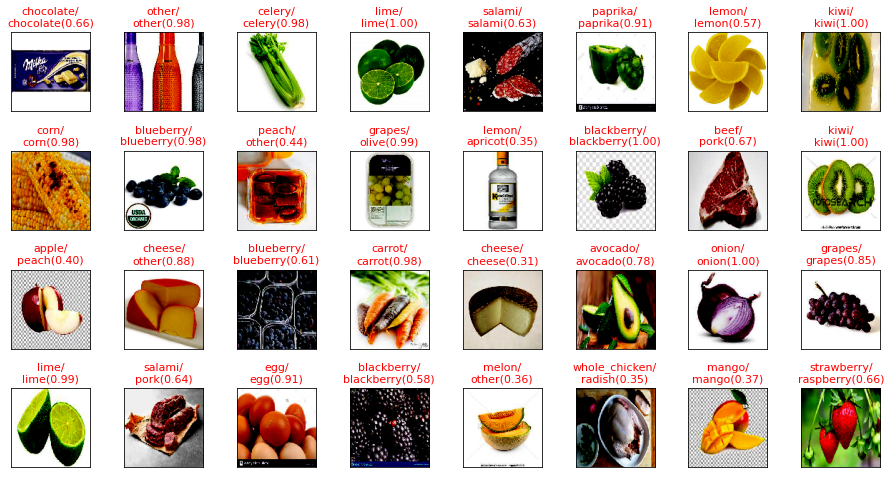

In [20]:
# show first 32 images in test set
fig = data_helpers.image_grid(images[:32], labels[:32], ind2class, n_row=4, n_col=8, deprocess_func=plot_deprocess_func,
                              predict=predict_i[:32], predict_proba=predict_proba[:32], hspace=0.5)

if logging:
    fig.savefig(os.path.join(logdir, 'figures/test_examples.png'), bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

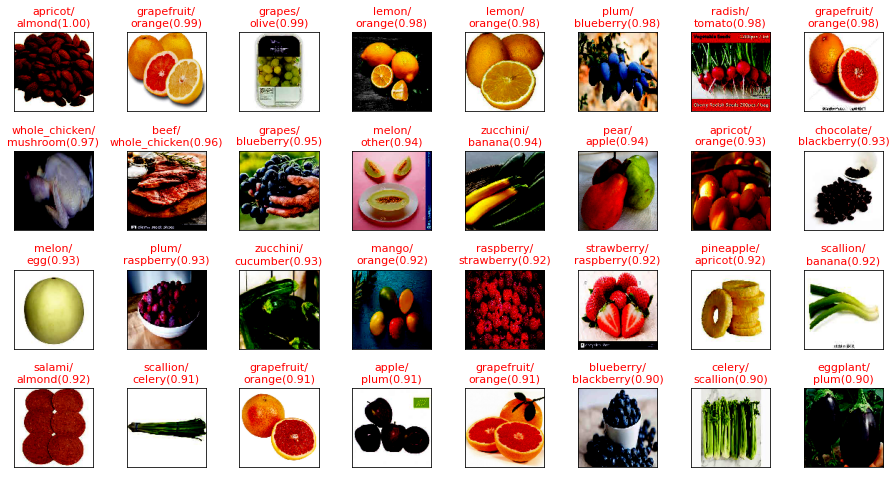

In [21]:
# show worst misclassifications
ind_sorted = np.argsort(predict_proba[ind_misclassified])[::-1]
ind_sorted = ind_misclassified[ind_sorted]

fig = data_helpers.image_grid(images[ind_sorted], labels[ind_sorted], ind2class, n_row=4, n_col=8, deprocess_func=plot_deprocess_func,
                              predict=predict_i[ind_sorted], predict_proba=predict_proba[ind_sorted], hspace=0.5)

if logging:
    fig.savefig(os.path.join(logdir, 'figures/worst_test_examples.png'), bbox_inches='tight')

### Get confusion matrix and metrics 

 - Get model performance metrics
 - Get confusion matrix

In [22]:
# generate evaluation dataframe
eval_df = pd.DataFrame({'predicted': predict_i, 'actual': np.nonzero(labels)[1]})
eval_df.predicted = eval_df.predicted.apply(lambda x: ind2class[x])
eval_df.actual = eval_df.actual.apply(lambda x: ind2class[x])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(eval_df.predicted, eval_df.actual)
micro_precision = precision_score(eval_df.predicted, eval_df.actual, average='micro')
micro_recall = recall_score(eval_df.predicted, eval_df.actual, average='micro')
macro_precision = precision_score(eval_df.predicted, eval_df.actual, average='macro')
macro_recall = recall_score(eval_df.predicted, eval_df.actual, average='macro')

print(f"Accuracy: {accuracy}\nMicro-precision: {micro_precision}\nMacro-precision: {macro_precision}\nMicro-recall: {micro_recall}\nMacro-recall: {macro_recall}\n")

Accuracy: 0.7038251366120218
Micro-precision: 0.7038251366120218
Macro-precision: 0.6941063132660189
Micro-recall: 0.7038251366120218
Macro-recall: 0.7383622906562394



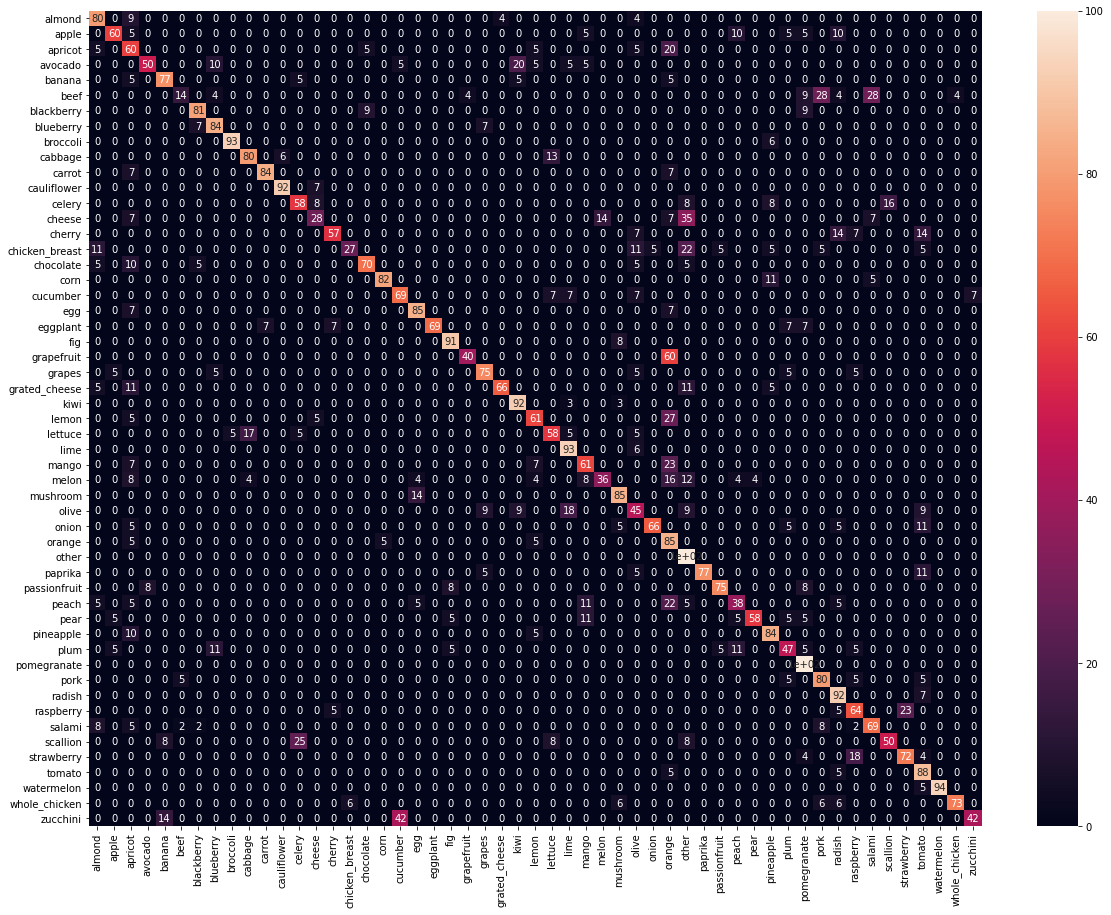

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = pd.DataFrame(confusion_matrix(eval_df['actual'], eval_df['predicted'], labels=classes, normalize='true'),
                           index=classes, columns=classes)
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap((conf_matrix*100).astype(np.int), annot=True)

if logging:
    fig.savefig(os.path.join(logdir, 'figures/confusion_matrix.png'), bbox_inches='tight')

### Log results and save the model

In [25]:
from tensorflow.keras.models import save_model
import json

# define results dictionary
results = {'params': PARAMS,
           'eval_df': eval_df.to_dict(), 
           'history': history, 
           'metrics': {'accuracy': accuracy, 
                       'micro-precision': micro_precision, 
                       'macro-precision': macro_precision, 
                       'micro-recall': micro_recall, 
                       'macro-recall': macro_recall}, 
           'model_path': logdir}

# save the model
if saving:
    save_model(model, logdir)

# save logging dict to json-file
if logging:
    with open(os.path.join(logdir, 'results_classifier.json'), 'w+') as f:
        json.dump(results, f)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: logs/experiments/test_all_2020_09_16-11:32/assets


### Tune the sliding window algorithm

#### Get validation data

In [26]:
log_image_stats = False

# get validation set with "real" fridge scenes
val_real_data = data_helpers.get_validation_dict(PARAMS['real_validation_path'], classes, verbose=0)

# get validation set with "artificial" fridge scenes
val_artificial_data = data_helpers.get_validation_dict(PARAMS['artificial_validation_path'], classes, verbose=0)

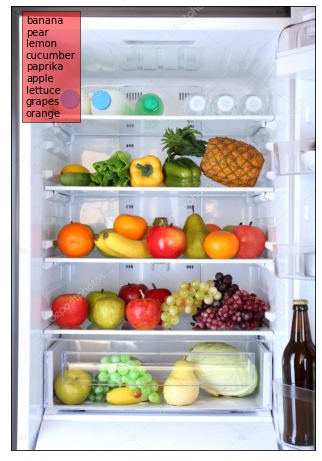

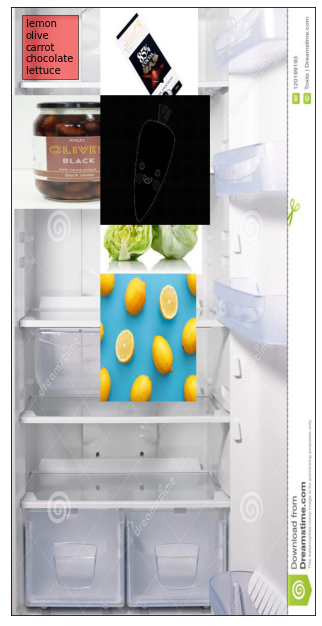

In [28]:
# show example pictures
fig = training_vis.show_example_picures_validation(val_real_data, 15,
                                                   logging=logging,
                                                   logpath=os.path.join(logdir, 'figures/example_validation_real.png'))

fig = training_vis.show_example_picures_validation(val_artificial_data, 15,
                                                   logging=logging,
                                                   logpath=os.path.join(logdir, 'figures/example_validation_artificial.png'))


### Run sliding window algorithm on validation set

The following cell runs the sliding window algorithm with the specified parameters over the whole validation set (both artificial and real) and saves intermediate results in a temporaray dataframe `sliding_df`.

The algorithm does not yet apply thresholding or non-maximum suppression. This dataframe therefore contains the classification results for __ALL__ boxes (without thresholding). 

 - `scaling_factors` are the different scaling factors for the image pyramid
 - `sliding_strides` the are different strides for each level of the pyramid
 
Using the results from this dataframe `sliding_df`, we can later perform thresholding and non-maximum suppression (which require a lot less computational power than the image classification itself) and find their optimal values. 

In [31]:
# define preprocessing function
if PARAMS['base_net'] == 'resnet50':
    preprocess_function = preprocess_resnet50
elif PARAMS['base_net'] == 'mobilenet_v2':
    preprocess_function = preprocess_mobilenet_v2

results = tuning_helpers.tuning_loop_sliding_window_tight(PARAMS['scaling_factors'], PARAMS['sliding_strides'], PARAMS['thr_list'], PARAMS['overlap_thr_list'],
                                                      val_real_data, val_artificial_data, ind2class, classes,
                                                      model, preprocess_function, PARAMS['target_size'][0],
                                                      log_image_stats=log_image_stats)


  0%|          | 0/2 [00:00<?, ?it/s]

Run on real data...


  0%|          | 0/2 [00:00<?, ?it/s]

Run on artificial data...


100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


In [32]:
# save tuning results to json-file
if logging:
    with open(os.path.join(logdir, 'results_tuning.json'), 'w+') as f:
        json.dump(results, f)

### Select combination of hyperparameters with highest F1-score

In [33]:
# get summary metrics for each set of sliding window parameters
metrics_df = pd.DataFrame(results)
metrics_df.scaling_factors = metrics_df.scaling_factors.astype(str)

metrics_df = metrics_df.groupby(['data_type', 'thr', 'overlap_thr', 'scaling_factors'])['precision', 'recall'].mean()
metrics_df['f1'] = 2*metrics_df.precision*metrics_df.recall/(metrics_df.precision + metrics_df.recall)
metrics_df['f1'] = metrics_df['f1'].fillna(0)
metrics_df = metrics_df.reset_index()

# save summary metrics evaluation to json
if logging:
    metrics_df.to_json(os.path.join(logdir, 'metrics_df.json'))

# aggregate metrics per type of dataset
metrics_per_dataset = metrics_df.pivot_table(index=['thr', 'overlap_thr', 'scaling_factors'],
                                       columns=['data_type'],
                                       values=['f1', 'precision', 'recall'])
new_columns = [a + '_' + b for (a,b) in metrics_per_dataset.columns]
metrics_per_dataset.columns = new_columns
metrics_per_dataset['f1'] = (metrics_per_dataset['f1_artificial'] +  metrics_per_dataset['f1_real'])/2.
metrics_per_dataset['precision'] = (metrics_per_dataset['precision_artificial'] +  metrics_per_dataset['precision_real'])/2.
metrics_per_dataset['recall'] = (metrics_per_dataset['recall_artificial'] +  metrics_per_dataset['recall_real'])/2.


# get optimal parameters (optimizing f1 score)
opt_thr, opt_overlap_thr, opt_scaling_factors = metrics_per_dataset.loc[metrics_per_dataset.idxmax()['f1']].name

# get optimal scaling factors as list and find corresponding sliding strides
opt_scaling_factors = eval(opt_scaling_factors) # transform from str to list
opt_sliding_strides = [PARAMS['sliding_strides'][PARAMS['scaling_factors'].index(f)] for f in opt_scaling_factors]


tuning_final = {'opt_thr': opt_thr,
                'opt_overlap_thr': opt_overlap_thr,
                'opt_scaling_factors': opt_scaling_factors,
                'opt_sliding_strides': opt_sliding_strides,
                }
tuning_final.update(metrics_per_dataset.loc[metrics_per_dataset.idxmax()['f1']].to_dict())

# save final parameters to json file
if logging:
    pd.Series(tuning_final).to_json(os.path.join(logdir, 'tuning_final.json'))

# show final parameters
print("Tuned parameters:")
print(pd.Series(tuning_final))

Tuned parameters:
opt_thr                      0.9
opt_overlap_thr              0.2
opt_scaling_factors        [1.0]
opt_sliding_strides         [32]
f1_artificial           0.635514
f1_real                 0.564516
precision_artificial    0.607143
precision_real             0.875
recall_artificial       0.666667
recall_real             0.416667
f1                      0.600015
precision               0.741071
recall                  0.541667
dtype: object


/Users/drews/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


### Generate some summary figures for the tuning process

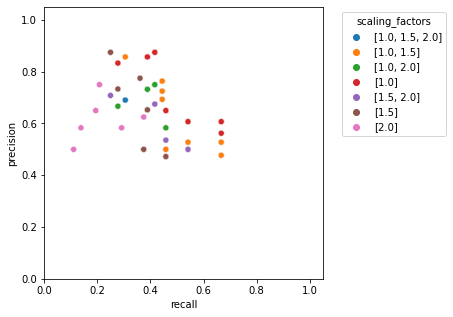

In [34]:
fig = training_vis.scatter_precision_recall(metrics_df,
                               logging=logging,
                               logpath=os.path.join(logdir, 'figures/precision_recall.png'))

/Users/drews/Documents/DSR/dsr_projects/deep-food/models/training_vis.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "logging" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(logpath, logging=False, logpath='')
/Users/drews/Documents/DSR/dsr_projects/deep-food/models/training_vis.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "logpath" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(logpath, logging=False, logpath='')


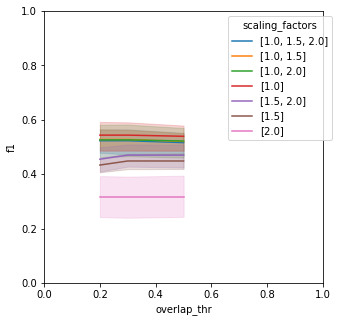

In [35]:
fig = training_vis.lines_f1_overlap_thr(metrics_df,
                               logging=logging,
                               logpath=os.path.join(logdir, 'figures/f1_overlap_thr.png'))


/Users/drews/Documents/DSR/dsr_projects/deep-food/models/training_vis.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "logging" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(logpath, logging=False, logpath='')
/Users/drews/Documents/DSR/dsr_projects/deep-food/models/training_vis.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "logpath" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(logpath, logging=False, logpath='')


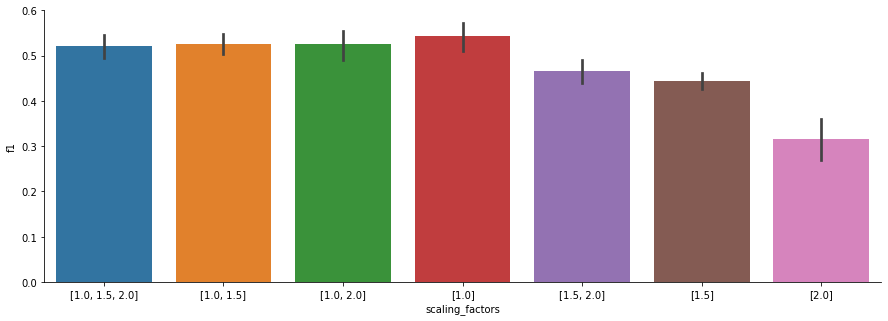

In [36]:
fig = training_vis.bars_f1_scaling_factors(metrics_df,
                               logging=logging,
                               logpath=os.path.join(logdir, 'figures/f1_scaling_factors.png'))

### Generate example output pictures

In [ ]:
def generate_output_pictures(dataset, savepath, keys):
    """Small helper function to be applied to both real and artificial dataset
    """
    
    for k in keys:
        img = dataset[k]['image']
        # perform object detection with final model
        pred_labels, probabilities, x0, y0, windowsize = model_helpers.object_detection_sliding_window(model, 
                                                                                         img, 
                                                                                         preprocess_function, 
                                                                                         PARAMS['target_size'][0], 
                                                                                         ind2class, 
                                                                                         opt_scaling_factors, 
                                                                                         opt_sliding_strides, 
                                                                                         opt_thr, 
                                                                                         opt_overlap_thr)

        # visualize results
        fig = model_helpers.visualize_predictions(img, 
                                                  pred_labels, 
                                                  probabilities, 
                                                  x0, 
                                                  y0,
                                                  windowsize)


        if logging:
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            fig.savefig(os.path.join(savepath, f'real_{k}.png'), bbox_inches='tight')
            

# save some results for artificial dataset
savepath = os.path.join(logdir, 'figures', 'results', 'artificial')
generate_output_pictures(val_artificial_data, savepath, keys=np.arange(0, 30, dtype='int'))

# save results for real dataset
savepath = os.path.join(logdir, 'figures', 'results', 'real')
generate_output_pictures(val_real_data, savepath, keys=list(val_real_data.keys()))